# Training a Swin transformer model to predict layer annotations

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from transformers import TFSwinModel
import datetime
from sklearn.model_selection import train_test_split
print(tf.__version__)

2025-07-16 17:27:20.734904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752701240.748039   24201 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752701240.752433   24201 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 17:27:20.766093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/suraj/anaconda3/envs/vision-2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress no

2.18.1


In [2]:
with h5py.File('/home/suraj/Git/SCR-Progression/Duke_Control_processed.h5', 'r') as f:
    images = f['images'][:]  # shape: (N, 224, 224)
    layer_maps = f['layer_maps'][:]  # shape: (N, 224, 2) or (N, 224, 3)

In [3]:
# add another dimension to images for compatibility
if images.ndim == 3:
    images = np.expand_dims(images, axis=-1)

# We only want ILM and BM (first and last columns) for training
layer_maps = layer_maps[:, :, [0, 2]]  # if shape is (N, 224, 3)

In [ ]:
#Testing with only 1000 samples
#images = images[:1000]
#layer_maps = layer_maps[:1000]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    images, layer_maps, test_size=0.2, random_state=42
)

In [6]:
if X_train.shape[-1] == 1:
    X_train = np.repeat(X_train, 3, axis=-1)
if X_test.shape[-1] == 1:
    X_test = np.repeat(X_test, 3, axis=-1)

print("X_train shape after conversion:", X_train.shape)
print("X_test shape after conversion:", X_test.shape)

X_train shape after conversion: (800, 224, 224, 3)
X_test shape after conversion: (200, 224, 224, 3)


In [7]:
# Load Swin-Tiny base model for feature extraction
swin_model = TFSwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
print("Swin model loaded successfully!")
print(f"Model expected channels: {swin_model.config.num_channels}")
print(f"Model input size: {swin_model.config.image_size}")

# The issue might be with tensor format - Swin expects NCHW (channels first) format
# Let's try transposing the tensor from NHWC to NCHW
test_batch = X_train[:2]  # Take 2 samples
print(f"Original batch shape: {test_batch.shape}")

# Normalize first
test_batch_norm = test_batch.astype(np.float32) / 255.0

# Transpose from NHWC to NCHW (TensorFlow to PyTorch format)
test_batch_transposed = np.transpose(test_batch_norm, (0, 3, 1, 2))
print(f"Transposed batch shape: {test_batch_transposed.shape}")

test_batch_tensor = tf.convert_to_tensor(test_batch_transposed, dtype=tf.float32)
print(f"Final tensor shape: {test_batch_tensor.shape}")
print(f"Final tensor dtype: {test_batch_tensor.dtype}")

# Try to run the model on this transposed batch
try:
    outputs = swin_model({"pixel_values": test_batch_tensor})
    print("Model ran successfully with transposed input!")
    print(f"Output shape: {outputs.last_hidden_state.shape}")
except Exception as e:
    print(f"Error with transposed input: {e}")
    
    # If that doesn't work, let's try with the original NHWC format but ensure proper preprocessing
    print("\nTrying original format with proper preprocessing...")
    test_batch_original = tf.convert_to_tensor(test_batch_norm, dtype=tf.float32)
    
    try:
        outputs = swin_model(test_batch_original)  # Try without dict wrapper
        print("Model ran successfully with direct tensor input!")
        print(f"Output shape: {outputs.last_hidden_state.shape}")
    except Exception as e2:
        print(f"Error with direct input: {e2}")
        
        # Try with different preprocessing
        print("\nTrying with ImageNet normalization...")
        # ImageNet normalization
        mean = tf.constant([0.485, 0.456, 0.406])
        std = tf.constant([0.229, 0.224, 0.225])
        
        test_batch_imagenet = (test_batch_norm - mean) / std
        test_batch_imagenet_tensor = tf.convert_to_tensor(test_batch_imagenet, dtype=tf.float32)
        
        try:
            outputs = swin_model({"pixel_values": test_batch_imagenet_tensor})
            print("Model ran successfully with ImageNet normalization!")
            print(f"Output shape: {outputs.last_hidden_state.shape}")
        except Exception as e3:
            print(f"Error with ImageNet normalization: {e3}")


I0000 00:00:1752701251.145434   24201 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 754 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFSwinModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSwinModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFSwinModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinMo

Swin model loaded successfully!
Model expected channels: 3
Model input size: 224
Original batch shape: (2, 224, 224, 3)
Transposed batch shape: (2, 3, 224, 224)
Final tensor shape: (2, 3, 224, 224)
Final tensor dtype: <dtype: 'float32'>
Model ran successfully with transposed input!
Output shape: (2, 49, 768)


In [8]:
def extract_swin_features(images, base_model, batch_size=8):
    """
    Extract features from images using Swin Transformer
    """
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        
        # Ensure we have RGB channels (should already be done)
        if batch.shape[-1] == 1:
            batch_rgb = np.repeat(batch, 3, axis=-1)
        else:
            batch_rgb = batch
            
        # Convert to float32 and normalize to [0,1]
        batch_rgb = batch_rgb.astype(np.float32) / 255.0
        
        # Transpose from NHWC to NCHW format (TensorFlow to PyTorch format)
        batch_rgb = np.transpose(batch_rgb, (0, 3, 1, 2))
        
        # Convert to TensorFlow tensor
        batch_rgb = tf.convert_to_tensor(batch_rgb, dtype=tf.float32)
        
        # Extract features using Swin
        outputs = base_model({"pixel_values": batch_rgb})
        batch_features = outputs.last_hidden_state.numpy()
        features.extend(batch_features)
        
        if i % 100 == 0:
            print(f"Processed {i}/{len(images)} images")
            
    return np.array(features)

In [9]:
# Extract features from training and test data
print("Extracting features from training data")
X_train_features = extract_swin_features(X_train, swin_model, batch_size=8)

print("Extracting features from test data")
X_test_features = extract_swin_features(X_test, swin_model, batch_size=8)

print(f"Training features shape: {X_train_features.shape}")
print(f"Test features shape: {X_test_features.shape}")
print("Feature extraction completed!")

Extracting features from training data
Processed 0/800 images
Processed 200/800 images
Processed 400/800 images
Processed 600/800 images
Extracting features from test data
Processed 0/200 images
Training features shape: (800, 49, 768)
Test features shape: (200, 49, 768)
Feature extraction completed!


In [10]:
# Inspect Swin model configuration
print("Swin model configuration:")
print(swin_model.config)

# Verify input tensor shape
print("Input tensor shape:", X_train.shape)
print("Input tensor dtype:", X_train.dtype)

Swin model configuration:
SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bu

In [11]:
# Create regression head for Swin features
def create_swin_regression_head(feature_shape):
    """
    Create a regression head that takes Swin features and predicts layer coordinates
    """
    input_layer = tf.keras.layers.Input(shape=feature_shape)
    
    # Global average pooling to reduce sequence dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(input_layer)
    
    # Dense layers for regression
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Output layer: predict 224 points for 2 layers (ILM and BM)
    x = tf.keras.layers.Dense(224 * 2, activation='linear')(x)
    output = tf.keras.layers.Reshape((224, 2))(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=output)

# Create and compile Swin regression model
swin_regression_model = create_swin_regression_head(X_train_features.shape[1:])
swin_regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

print("Swin regression model created successfully!")
print(f"Input feature shape: {X_train_features.shape[1:]}")
print(f"Output shape: (224, 2)")
swin_regression_model.summary()

Swin regression model created successfully!
Input feature shape: (49, 768)
Output shape: (224, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 768)]         0         
                                                                 
 global_average_pooling1d (  (None, 768)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dropout_24 (Dropout)        (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_25 (Dropout)        

In [ ]:
# Create datasets for Swin features
swin_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_features, y_train)).batch(16).shuffle(100)
swin_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_features, y_test)).batch(16)

# TensorBoard callback for Swin model
swin_log_dir = "logs/swin_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
swin_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=swin_log_dir, histogram_freq=1)

print("Starting Swin model training...")
# Train Swin regression model
swin_history = swin_regression_model.fit(
    swin_train_dataset,
    validation_data=swin_test_dataset, 
    epochs=50,  # Slightly more epochs since we have rich features
    callbacks=[swin_tensorboard_callback]
)

Starting Swin model training...
Epoch 1/30


I0000 00:00:1752701306.663838   24280 service.cc:148] XLA service 0x7d9d440ac800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752701306.663865   24280 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-07-16 17:28:26.668778: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752701306.747591   24280 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 2s 9ms/step - loss: 0.1780 - mean_absolute_error: 0.3409 - val_loss: 0.0495 - val_mean_absolute_error: 0.1583
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0289 - mean_absolute_error: 0.1274 - val_loss: 0.0040 - val_mean_absolute_error: 0.0477
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0827 - val_loss: 0.0026 - val_mean_absolute_error: 0.0401
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_absolute_error: 0.0715 - val_loss: 0.0024 - val_mean_absolute_error: 0.0376
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_error: 0.0653 - val_loss: 0.0031 - val_mean_absolute_error: 0.0447
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_error: 0.0624 - val_loss: 0.0026 - val_mean_absolute_error: 0.0406
Epoch 7/30
50/50 [=====================

In [13]:
# Evaluate Swin model
swin_test_loss = swin_regression_model.evaluate(swin_test_dataset)
print(f"Swin Test MSE: {swin_test_loss[0]:.6f}")
print(f"Swin Test MAE: {swin_test_loss[1]:.6f}")

# Save Swin model
swin_regression_model.save('Swin_regression_model_run2.h5')
print("Swin model saved as 'Swin_regression_model_run2.h5'")

13/13 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0380
Swin Test MSE: 0.002393
Swin Test MAE: 0.037994
Swin model saved as 'Swin_regression_model_run2.h5'


/home/suraj/anaconda3/envs/vision-2/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plotting layer annotations for test samples...
1/1 [==============================] - 0s 69ms/step


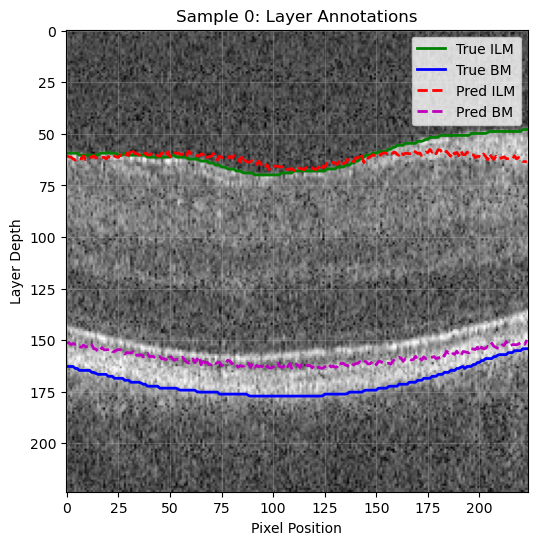

Sample 0 - ILM MAE: 4.2966, BM MAE: 11.9982
1/1 [==============================] - 0s 16ms/step


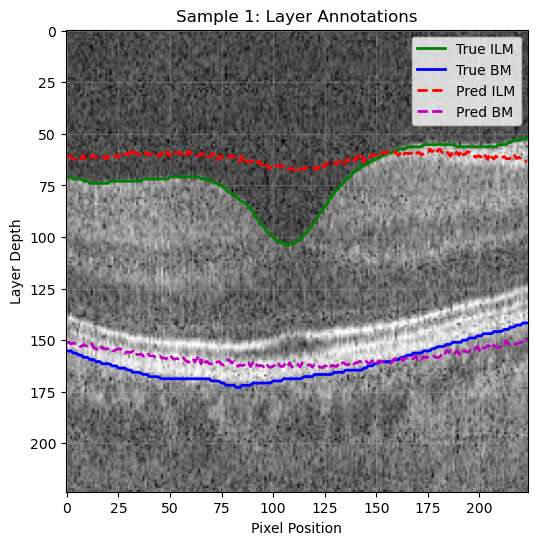

Sample 1 - ILM MAE: 12.5154, BM MAE: 6.3546
1/1 [==============================] - 0s 16ms/step


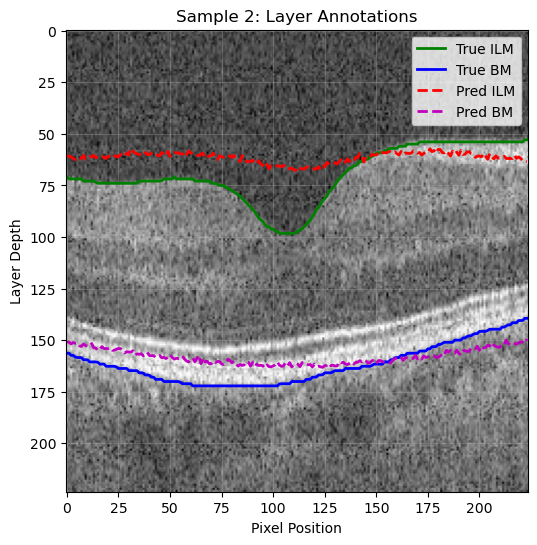

Sample 2 - ILM MAE: 12.1106, BM MAE: 7.3350


In [14]:
import matplotlib.pyplot as plt

layer_min = 0  # e.g., 0
layer_max = 224  # e.g., 224

def denormalize_layers(layers, layer_min, layer_max):
    return layers * (layer_max - layer_min) + layer_min

def plot_layer_annotations(model, images, layer_maps, features, num_samples=5):
    """
    Plot actual and predicted layer annotations for a few samples.
    """
    for idx in range(num_samples):
        img = images[idx]
        true_layers = denormalize_layers(layer_maps[idx], layer_min, layer_max)
        # Model expects batch dimension
        pred_layers = model.predict(features[idx:idx+1])[0]
        pred_layers = denormalize_layers(pred_layers, layer_min, layer_max)

        plt.figure(figsize=(10, 6))
        plt.imshow(img[:, :, 0], cmap='gray')
        plt.plot(range(224), true_layers[:, 0], 'g-', linewidth=2, label='True ILM')
        plt.plot(range(224), true_layers[:, 1], 'b-', linewidth=2, label='True BM')
        plt.plot(range(224), pred_layers[:, 0], 'r--', linewidth=2, label='Pred ILM')
        plt.plot(range(224), pred_layers[:, 1], 'm--', linewidth=2, label='Pred BM')
        plt.title(f"Sample {idx}: Layer Annotations")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlabel('Pixel Position')
        plt.ylabel('Layer Depth')
        plt.show()
        
        # Calculate and print errors for this sample
        mae_ilm = np.mean(np.abs(pred_layers[:, 0] - true_layers[:, 0]))
        mae_bm = np.mean(np.abs(pred_layers[:, 1] - true_layers[:, 1]))
        print(f"Sample {idx} - ILM MAE: {mae_ilm:.4f}, BM MAE: {mae_bm:.4f}")

# Plot predictions on test samples
print("Plotting layer annotations for test samples...")
plot_layer_annotations(swin_regression_model, X_test, y_test, X_test_features, num_samples=3)
